## Homework №2

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the machine translation translation task.

Please, select the language you prefer from the [OPUS webpage](http://opus.nlpl.eu/News-Commentary.php). You need the plain txt format which is availabe in the bottom of the page (last table, lower-left triangle (`Bottom-left triangle: download plain text files (MOSES/GIZA++)`)).


Please, select the language pairs with English (so it might be `en-ar` or `en-ru` etc.)

English will be the target language.

__Please, avoid the language pairs with small corpus (e.g. the en-ja). The link should be green if there is rather big dataset.__


After you downloaded the file, unzip in the working directory (`unzip <FILE_NAME>` in the console. Use `! unzip <FILE NAME>` in Colab).

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* Pre-trained word embeddings for the source and target languages

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [4]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install subword-nmt
! pip install nltk
! pip install torchtext
! pip install spacy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user install

In [ ]:
# Uncomment the following cell on Colab
# ! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/homeworks/homework02/utils.py -nc
# ! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/homeworks/homework02/my_network.py -nc

In [2]:
import os

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [6]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

Change the filenames for your language pairs.

In [8]:
# E.g. here comes the download for the en-ru language pair
!wget http://opus.nlpl.eu/download.php?f=News-Commentary/v11/moses/en-es.txt.zip -O en-es.txt.zip

--2020-06-17 23:41:56--  http://opus.nlpl.eu/download.php?f=News-Commentary/v11/moses/en-es.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-News-Commentary/v11/moses/en-es.txt.zip [following]
--2020-06-17 23:41:56--  https://object.pouta.csc.fi/OPUS-News-Commentary/v11/moses/en-es.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28106064 (27M) [application/zip]
Saving to: ‘en-es.txt.zip’

en-es.txt.zip       100%[===================>]  26.80M   655KB/s    in 31s     

2020-06-17 23:42:28 (876 KB/s) - ‘en-es.txt.zip’ saved [28106064/28106064]



In [9]:
# And unzip it
!unzip en-es.txt.zip

Archive:  en-es.txt.zip
  inflating: README                  
  inflating: LICENSE                 
  inflating: News-Commentary.en-es.en  
  inflating: News-Commentary.en-es.es  
  inflating: News-Commentary.en-es.ids  


In [11]:
with open('News-Commentary.en-es.es', 'r') as iofile:
    source = iofile.readlines()
with open('News-Commentary.en-es.en', 'r') as iofile:
    target = iofile.readlines()
assert not any(['\t' in x for x in source]), 'Tabulation is used as delimiter and should not be present in the source dataset'
assert not any(['\t' in x for x in target]), 'Tabulation is used as delimiter and should not be present in the target dataset'

The cell below combines the pairs into one dataset. `MAX_LENGTH` const can be adjusted, but avoid the phrases longer than 100 tokens.

In [12]:
combined = ['\t'.join([source[i].replace('\n', ''), target[i]]).replace('"', '')
     for i in range(1, len(source)) if 2<len(tokenize(source[i]))<60 and 2<len(tokenize(target[i]))<60]

In [13]:
with open('combined_dataset.txt', 'w') as iofile:
    iofile.writelines(combined)

In [14]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [15]:
dataset = torchtext.data.TabularDataset(
    path='./combined_dataset.txt',
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [16]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [17]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 181724
Number of validation examples: 11358
Number of testing examples: 34073


You can adjust the `MIN_FREQ` as well (stick to ~10k unique tokens in each language).

In [18]:
MIN_FREQ_SRC = 40
MIN_FREQ_TRG = 45

In [19]:
SRC.build_vocab(train_data, min_freq = MIN_FREQ_SRC)
TRG.build_vocab(train_data, min_freq = MIN_FREQ_TRG)

In [20]:
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (EN) vocabulary: {len(TRG.vocab)}")

Unique tokens in source vocabulary: 7702
Unique tokens in target (EN) vocabulary: 6559


Here are tokens from original corpus:

In [21]:
SRC.vocab.itos[::1000]

['<unk>',
 'científicos',
 'derrota',
 'historias',
 'brillante',
 'miseria',
 'definido',
 'ropa']

And from target (EN) corpus:

In [22]:
TRG.vocab.itos[::1000]

['<unk>',
 'include',
 'generations',
 'coordinated',
 'widening',
 'insolvent',
 'rapprochement']

And here is example from train dataset:

In [23]:
print(vars(train_data.examples[9]))

{'src': ['será', 'una', 'escena', 'que', 'fácilmente', 'hubiera', 'resultado', 'familiar', 'a', 'líderes', 'soviéticos', 'como', 'leonid', 'brézhnev', 'y', 'nikita', 'kruschev', ',', 'quienes', 'recibían', 'el', 'saludo', 'sobre', 'la', 'tumba', 'de', 'lenin', '.'], 'trg': ['it', 'will', 'be', 'a', 'scene', 'that', 'would', 'easily', 'have', 'been', 'familiar', 'to', 'soviet', 'leaders', 'like', 'leonid', 'brezhnev', 'and', 'nikita', 'khrushchev', ',', 'taking', 'the', 'salute', 'atop', 'lenin', '’', 's', 'tomb', '.']}


Let's check the length distributions:

Length distribution in Train data


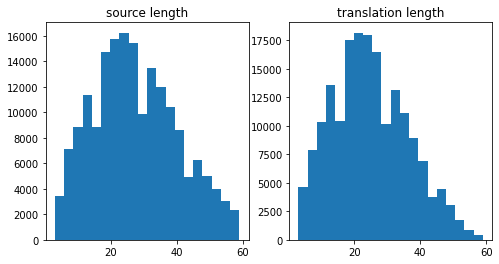

In [24]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


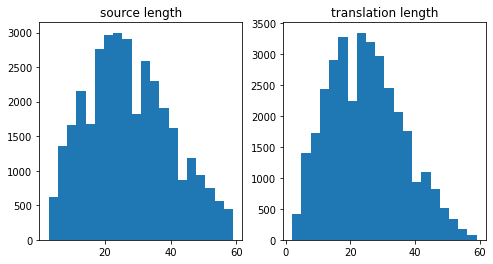

In [25]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
device

device(type='cpu')

In [28]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [29]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 256]
	[.src]:[torch.LongTensor of size 60x256]
	[.trg]:[torch.LongTensor of size 58x256]
torch.Size([60, 256]) torch.Size([58, 256])


In [30]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [31]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,371,999 trainable parameters


In [34]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [39]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

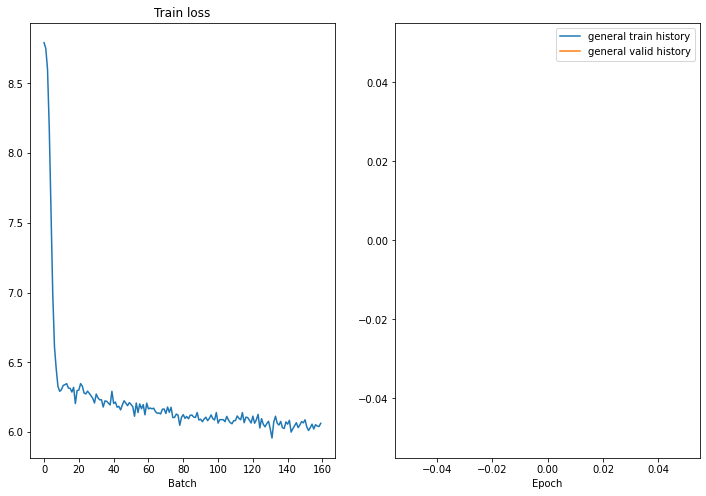

In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

Take a look at the example translation:

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set.

Here are some thresholds you might refer to (they may vary for different language pairs, but are good references for pairs line EN-FR or EN-GE):

* __18__ – good starting point

* __20__ – better

* __25__ – excellent score